### GEOGRAPHIC DATA SCIENCE - part 3 - spatial autocorrelation and clustering

Guest lecture by Sándor Juhász | [sandorjuhasz.com](sandorjuhasz.com)
<br>


In [106]:
# import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import shapely
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine_vector, Unit
import pyfixest as pf

**Geolocated Twitter social network inside Boston**

In [61]:
# Boston -- Twitter connections
el = pd.read_csv("../data/boston_US_twitter_edgelist.csv", sep=";")

In [132]:
# Boston census data
census = gpd.read_file("../data/boston_census_tracts.geojson")
census["lat"] = census.centroid.y
census["lon"] = census.centroid.x

/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_79715/1293045543.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  census["lat"] = census.centroid.y
/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_79715/1293045543.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  census["lon"] = census.centroid.x


In [63]:
# construct nodelist
nodelist = pd.DataFrame({"tract_id": pd.concat([el["tract_home1"], el["tract_home2"]]).unique()})

# add geometry from census tract table
nodelist = pd.merge(
    nodelist,
    census[["tract_id", "lat", "lon"]],
    on="tract_id",
    how="left"
)

# centroid of census tracts
nodelist = gpd.GeoDataFrame(nodelist)

In [64]:
# point for nodes
def create_point(r):
    return Point([r["lon"],r["lat"]])

In [68]:
# nodelist geodataframe construction
nodelist["geometry"] = nodelist.apply(create_point, axis=1)
nodes_gdf = gpd.GeoDataFrame(nodelist, geometry="geometry", crs="epsg:4326")

In [69]:
# construct edgelist
el = pd.merge(
    el,
    census,
    left_on="tract_home1",
    right_on="tract_id",
    how="left"
)
el = pd.merge(
    el,
    census,
    left_on="tract_home2",
    right_on="tract_id",
    how="left",
    suffixes=["_1", "_2"]
)

In [73]:
# line for edges
def create_polyline(r):
    return LineString([[r["lon_1"],r["lat_1"]],[r["lon_2"],r["lat_2"]]])

In [76]:
# edgelist geodataframe construction
el["geometry"] = el.apply(create_polyline, axis=1)
edges_gdf = gpd.GeoDataFrame(el, geometry="geometry", crs="epsg:4326")

(-71.88759110596371, -70.47057856519389, 41.60862463551035, 43.557816927098344)

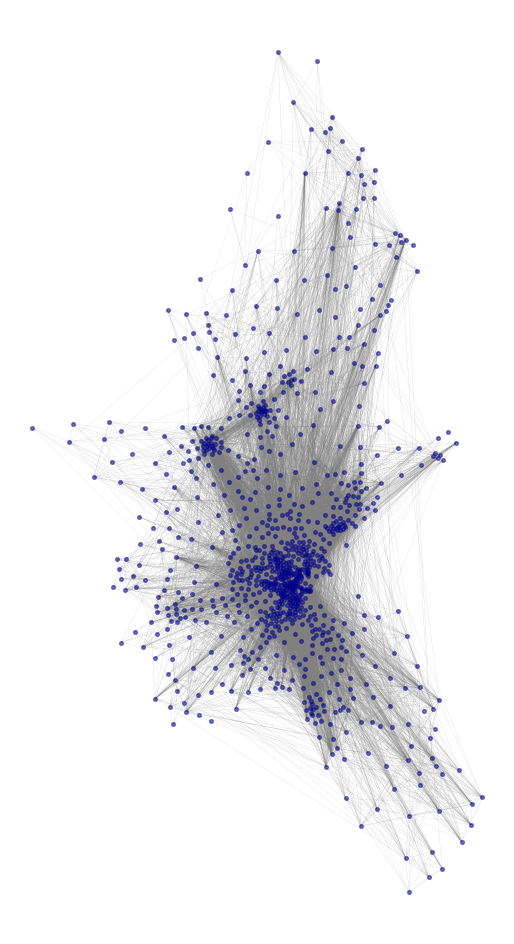

In [95]:
# map of social connections -- geolocated nodes and edges
fig, ax = plt.subplots(1,1, figsize=(12,12))
nodes_gdf.plot(ax=ax, markersize=7, color="darkblue", alpha=0.5, zorder=3)
edges_gdf.plot(ax=ax, lw=0.075, color="grey", alpha=0.4, zorder=2)
ax.axis('off')

**proximate things are more related than distant things?**

In [107]:
# distance calculation
edges_gdf["coords1"] = list(
    zip(edges_gdf["lat_1"], edges_gdf["lon_1"])
)
edges_gdf["coords2"] = list(
    zip(edges_gdf["lat_2"], edges_gdf["lon_2"])
)
edges_gdf["distance"] = haversine_vector(
    edges_gdf["coords1"].tolist(), edges_gdf["coords2"].tolist()
)

In [135]:
# Boston census data -- dominant racial group in tracts
census = gpd.read_file("../data/boston_census_tracts.geojson")
census["white_prop"] = np.round(census["white2012"] / census["population2012"], 3)
census["black_prop"] = np.round(census["black2012"] / census["population2012"], 3)
census["other_prop"] = 1 - census["white_prop"] - census["black_prop"]
census["other_prop"] = np.round(census["other_prop"], 3)
census = census[["tract_id", "white_prop", "black_prop", "other_prop"]]
census["race_props"] = census.apply(lambda row: [row["white_prop"], row["black_prop"], row["other_prop"]], axis=1)

# dominant group
group_labels = ["white", "black", "other"]
census["dominant_race"] = census[["white_prop", "black_prop", "other_prop"]].idxmax(axis=1).str.replace("_prop", "")

/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_79715/374418474.py:12: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  census["dominant_race"] = census[["white_prop", "black_prop", "other_prop"]].idxmax(axis=1).str.replace("_prop", "")


In [140]:
# variable manipulation for regression
reg_df = pd.DataFrame(edges_gdf[["nr_social_ties", "distance", "income2012_1", "income2012_2", "population2012_1", "population2012_2", "tract_home1", "tract_home2"]])

reg_df["log_social_ties"] = np.log10(reg_df["nr_social_ties"] + 1)
reg_df["log_distance"] = np.log10(reg_df["distance"] + 1)
reg_df["income_abs_diff"] = np.log10(abs(reg_df["income2012_1"] - reg_df["income2012_2"]) + 1)
reg_df["population_product"] = np.log10(reg_df["population2012_1"] * reg_df["population2012_2"] + 1)

reg_df = pd.merge(
    reg_df,
    census[["tract_id", "dominant_race"]],
    left_on="tract_home1",
    right_on="tract_id",
    how="left"
)
reg_df = pd.merge(
    reg_df,
    census[["tract_id", "dominant_race"]],
    left_on="tract_home2",
    right_on="tract_id",
    how="left",
    suffixes=["1", "2"]
)
reg_df["same_racial_group"] = np.where(reg_df["dominant_race1"] == reg_df["dominant_race2"], 1, 0)

In [146]:
# models
m1 = pf.feols("log_social_ties ~ population_product + log_distance | tract_home1 + tract_home2", data=reg_df)
m2 = pf.feols("log_social_ties ~ population_product + income_abs_diff | tract_home1 + tract_home2", data=reg_df)
m3 = pf.feols("log_social_ties ~ population_product + same_racial_group | tract_home1 + tract_home2", data=reg_df)
m4 = pf.feols("log_social_ties ~ population_product + log_distance + income_abs_diff + same_racial_group | tract_home1 + tract_home2", data=reg_df)

pf.etable([m1, m2, m3, m4], type="md")

index                          est1             est2             est3             est4
------------------  ---------------  ---------------  ---------------  ---------------
depvar              log_social_ties  log_social_ties  log_social_ties  log_social_ties
--------------------------------------------------------------------------------------
population_product           0.014           -0.011           0.025*           -0.005
                            (0.009)          (0.012)          (0.010)          (0.011)
log_distance             -0.188***                                          -0.168***
                            (0.004)                                            (0.004)
income_abs_diff                           -0.067***                         -0.034***
                                             (0.002)                           (0.002)
same_racial_group                                           0.044***           -0.001
                                               